# C-More

In [1]:
import tweepy
import pandas as pd

In [2]:
# Twitter API v2

bearer_token = ''

client = tweepy.Client(bearer_token=bearer_token)

### 1. Get tweets and store them in  a data frame

In [3]:
query = "Galp -is:retweet lang:pt"

# maches tweets with words Galp, excluding retweets for tweets in PT (app language?)

In [4]:
response = client.get_recent_tweets_count(query, granularity="day") # count of tweets for the last 7 days
# granularity can be minute, hour or day

In [5]:
for count in response.data:
    print(count)

{'end': '2022-07-15T00:00:00.000Z', 'start': '2022-07-14T12:06:14.000Z', 'tweet_count': 13}
{'end': '2022-07-16T00:00:00.000Z', 'start': '2022-07-15T00:00:00.000Z', 'tweet_count': 12}
{'end': '2022-07-17T00:00:00.000Z', 'start': '2022-07-16T00:00:00.000Z', 'tweet_count': 19}
{'end': '2022-07-18T00:00:00.000Z', 'start': '2022-07-17T00:00:00.000Z', 'tweet_count': 15}
{'end': '2022-07-19T00:00:00.000Z', 'start': '2022-07-18T00:00:00.000Z', 'tweet_count': 28}
{'end': '2022-07-20T00:00:00.000Z', 'start': '2022-07-19T00:00:00.000Z', 'tweet_count': 16}
{'end': '2022-07-21T00:00:00.000Z', 'start': '2022-07-20T00:00:00.000Z', 'tweet_count': 15}
{'end': '2022-07-21T12:06:14.000Z', 'start': '2022-07-21T00:00:00.000Z', 'tweet_count': 4}


In [6]:
total = 0

for i, count in enumerate(response.data):
    if i > 0 and i < 7:
        total += count['tweet_count']
        print(i, count['tweet_count'], total)

1 12 12
2 19 31
3 15 46
4 28 74
5 16 90
6 15 105


In [7]:
data = []

for tweet in tweepy.Paginator(client.search_recent_tweets, 
                              query, 
                              start_time="2022-07-15T00:00:00Z", 
                              end_time="2022-07-21T00:00:00Z", 
                              max_results=100, 
                              tweet_fields=['lang', 'created_at', 'public_metrics']).flatten(): # default limit is inf
    
    data.append([tweet.id, 
                 tweet.text, 
                 tweet.lang, 
                 tweet.public_metrics['retweet_count'], 
                 tweet.public_metrics['reply_count'], 
                 tweet.public_metrics['like_count'], 
                 tweet.public_metrics['quote_count'], 
                 tweet.created_at
                ])

df_galp = pd.DataFrame(data, columns = ['id', 'text', 'lang', 'retweets', 'replies', 'likes', 'quotes', 'created_at'])

In [8]:
df_galp

,id,text,lang,retweets,replies,likes,quotes,created_at
0,1549894462792499201,@xoao111 @psocialista @jvstorres Basicamente t...,pt,0,0,0,0,2022-07-20 23:10:10+00:00
1,1549884615564877826,Se o meu namorado vir isto lá vou eu ter que d...,pt,0,0,0,0,2022-07-20 22:31:02+00:00
2,1549879099128168453,"Estou sem palavras, a Ferrari não tem cartão G...",pt,0,0,0,0,2022-07-20 22:09:07+00:00
3,1549858582107226114,@p_leitao @filipagpinto Não Não deu. A cotação...,pt,0,1,0,0,2022-07-20 20:47:35+00:00
4,1549845974742360076,Quero levar a minha dama a um lugar caro\nAgor...,pt,0,1,3,1,2022-07-20 19:57:29+00:00
...,...,...,...,...,...,...,...,...
100,1547913901324414979,Galp disponibiliza 500 mil euros em combustíve...,pt,0,0,0,0,2022-07-15 12:00:07+00:00
101,1547908997889503232,"WRAP-UP ACAMPAMENTO 1.5\n\nO Acampamento 1.5, ...",pt,3,0,6,0,2022-07-15 11:40:38+00:00
102,1547905603309170688,"esta edição possível, os parceiros Upcoming En...",pt,0,0,1,0,2022-07-15 11:27:09+00:00
103,1547889048806572032,Galp e Repsol mais do que triplicam margens de...,pt,9,2,20,0,2022-07-15 10:21:22+00:00


In [9]:
df_galp['lang'].value_counts()

pt    105
Name: lang, dtype: int64

All our tweets are in Portuguese, so we can drop this column.

In [10]:
df_galp.drop('lang', axis=1, inplace=True)

In [11]:
df_galp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   id          105 non-null    int64              
 1   text        105 non-null    object             
 2   retweets    105 non-null    int64              
 3   replies     105 non-null    int64              
 4   likes       105 non-null    int64              
 5   quotes      105 non-null    int64              
 6   created_at  105 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(5), object(1)
memory usage: 5.9+ KB


### 2. Process text

In [12]:
import nltk
from nltk.tokenize import TweetTokenizer
import string

In [13]:
# select longest tweet for testing purposes

test_text = sorted(df_galp['text'], key=lambda x: len(x), reverse=True)[0]

test_text

'@FBenfica1904 @tiagojcgodinho @PSSantiago88 @SLBenfica que dobrar de espinha épico. Sabes que os gajos que estão colocados em "gaiolas douradas" na EDP ou na GALP nunca podem ser transferidos para outras empresas, certo? Um jogador de futebol pode ser transferido desde que todos os stakeholders aceitem... é função do Benfica ajudar'

In [14]:
# test tweet tokenizer

tweet_tokenizer = TweetTokenizer(reduce_len=True, strip_handles=True)
# redule_len=True replaces repeated character sequences of length 3 or greater with sequences of length 3
# examples: waaaaayyyy --> waaayyy
# strip_handles=True removes Twitter handles (@xxxx...)

tweet_tokenizer.tokenize(test_text)

['que',
 'dobrar',
 'de',
 'espinha',
 'épico',
 '.',
 'Sabes',
 'que',
 'os',
 'gajos',
 'que',
 'estão',
 'colocados',
 'em',
 '"',
 'gaiolas',
 'douradas',
 '"',
 'na',
 'EDP',
 'ou',
 'na',
 'GALP',
 'nunca',
 'podem',
 'ser',
 'transferidos',
 'para',
 'outras',
 'empresas',
 ',',
 'certo',
 '?',
 'Um',
 'jogador',
 'de',
 'futebol',
 'pode',
 'ser',
 'transferido',
 'desde',
 'que',
 'todos',
 'os',
 'stakeholders',
 'aceitem',
 '...',
 'é',
 'função',
 'do',
 'Benfica',
 'ajudar']

In [15]:
# punctuation

punct = string.punctuation

punct += "’" # add "’" to punct
punct += "…" # add "…" to punct
punct += "..." # add "..." to punct

punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’…...'

In [16]:
# tokenize text and remove punctuation

def tokens_nopunct(text):
    
    tokens = [token for token in TweetTokenizer(reduce_len=True, strip_handles=True).tokenize(text)]
    return [token for token in tokens if token not in punct]

In [17]:
# teste palavras compostas com hifenização

tokens_nopunct("caso de teste: palavra-com-hífenes - esta é uma palavra composta por justaposição que mantém o hífen")

['caso',
 'de',
 'teste',
 'palavra-com-hífenes',
 'esta',
 'é',
 'uma',
 'palavra',
 'composta',
 'por',
 'justaposição',
 'que',
 'mantém',
 'o',
 'hífen']

In [18]:
tokens_nopunct(test_text)

['que',
 'dobrar',
 'de',
 'espinha',
 'épico',
 'Sabes',
 'que',
 'os',
 'gajos',
 'que',
 'estão',
 'colocados',
 'em',
 'gaiolas',
 'douradas',
 'na',
 'EDP',
 'ou',
 'na',
 'GALP',
 'nunca',
 'podem',
 'ser',
 'transferidos',
 'para',
 'outras',
 'empresas',
 'certo',
 'Um',
 'jogador',
 'de',
 'futebol',
 'pode',
 'ser',
 'transferido',
 'desde',
 'que',
 'todos',
 'os',
 'stakeholders',
 'aceitem',
 'é',
 'função',
 'do',
 'Benfica',
 'ajudar']

In [19]:
# nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('portuguese')) # stopwords for portuguese

In [20]:
len(stopwords)

204

In [21]:
# remove stop words

def remove_stop(tokens):
    return [token for token in tokens if token not in stopwords]

In [22]:
pipeline = [str.lower, tokens_nopunct, remove_stop] # this will be our default pipeline
# lowercases words, tokenizes text, removes punctuation and removes stop words

def process_text(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [23]:
process_text(test_text, pipeline)

['dobrar',
 'espinha',
 'épico',
 'sabes',
 'gajos',
 'colocados',
 'gaiolas',
 'douradas',
 'edp',
 'galp',
 'nunca',
 'podem',
 'ser',
 'transferidos',
 'outras',
 'empresas',
 'certo',
 'jogador',
 'futebol',
 'pode',
 'ser',
 'transferido',
 'desde',
 'todos',
 'stakeholders',
 'aceitem',
 'função',
 'benfica',
 'ajudar']

In [24]:
df_galp['tokens'] = df_galp['text'].apply(process_text, pipeline=pipeline)

In [25]:
df_galp

,id,text,retweets,replies,likes,quotes,created_at,tokens
0,1549894462792499201,@xoao111 @psocialista @jvstorres Basicamente t...,0,0,0,0,2022-07-20 23:10:10+00:00,"[basicamente, todas, privatizações, levadas, c..."
1,1549884615564877826,Se o meu namorado vir isto lá vou eu ter que d...,0,0,0,0,2022-07-20 22:31:02+00:00,"[namorado, vir, lá, vou, ter, deixar, marketin..."
2,1549879099128168453,"Estou sem palavras, a Ferrari não tem cartão G...",0,0,0,0,2022-07-20 22:09:07+00:00,"[palavras, ferrari, cartão, galp, frota, https..."
3,1549858582107226114,@p_leitao @filipagpinto Não Não deu. A cotação...,0,1,0,0,2022-07-20 20:47:35+00:00,"[deu, cotação, brent, estável, durante, mês, m..."
4,1549845974742360076,Quero levar a minha dama a um lugar caro\nAgor...,0,1,3,1,2022-07-20 19:57:29+00:00,"[quero, levar, dama, lugar, caro, agora, pergu..."
...,...,...,...,...,...,...,...,...
100,1547913901324414979,Galp disponibiliza 500 mil euros em combustíve...,0,0,0,0,2022-07-15 12:00:07+00:00,"[galp, disponibiliza, 500, mil, euros, combust..."
101,1547908997889503232,"WRAP-UP ACAMPAMENTO 1.5\n\nO Acampamento 1.5, ...",3,0,6,0,2022-07-15 11:40:38+00:00,"[wrap-up, acampamento, 1.5, acampamento, 1.5, ..."
102,1547905603309170688,"esta edição possível, os parceiros Upcoming En...",0,0,1,0,2022-07-15 11:27:09+00:00,"[edição, possível, parceiros, upcoming, energi..."
103,1547889048806572032,Galp e Repsol mais do que triplicam margens de...,9,2,20,0,2022-07-15 10:21:22+00:00,"[galp, repsol, triplicam, margens, refinação, ..."


### 3. Extract keywords

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter

#### 3.1 Compute term frequency (with n-grams)

In [46]:
def compute_freq(df, tokenizer=tokens_nopunct, stop_words=stopwords, n_min=1, n_max=1, min_df=1):
    
    bow_vectorizer = CountVectorizer(lowercase=True, 
                                     tokenizer=tokenizer, 
                                     stop_words=stop_words, 
                                     ngram_range=(n_min, n_max), 
                                     min_df=min_df)
    
    cv_bow = bow_vectorizer.fit_transform(df['text'])
    df_cv_bow = pd.DataFrame(cv_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
    
    df_freq = pd.DataFrame(df_cv_bow.sum(axis = 0).index, columns=['token'])
    df_freq['freq'] = df_cv_bow.sum(axis = 0).values
    df_freq = df_freq.query('freq >= @min_df') # we are using 1 as default
    
    df_freq['n-gram size'] = df_freq['token'].map(lambda x: len(str.split(x))) # size of n-gram
    df_freq.drop(df_freq[df_freq['n-gram size'] > n_max].index, inplace=True) # removes rows with n-gram size greater than expected

    return df_freq

In [47]:
df_galp_freq = compute_freq(df_galp, n_max=2)

In [48]:
df_galp_freq['n-gram size'].value_counts()

2    1413
1    1091
Name: n-gram size, dtype: int64

In [49]:
# number of unigrams and bigrams for top-20 terms

df_galp_freq.sort_values('freq', ascending=False, inplace=True)
df_galp_freq.head(20)['n-gram size'].value_counts()

1    18
2     2
Name: n-gram size, dtype: int64

In [50]:
# number of unigrams and bigrams for top-20 terms (weighted)

df_galp_freq['weighted_freq'] = df_galp_freq['freq'] * df_galp_freq['n-gram size']
df_galp_freq.sort_values('weighted_freq', ascending=False, inplace=True)

df_galp_freq.head(20)['n-gram size'].value_counts()

2    11
1     9
Name: n-gram size, dtype: int64

We have a similar number of bigrams and unigrams because we are using only around 100 tweets for this analysis.

In [52]:
# top-20 terms (weighted)

df_galp_freq.set_index('token', inplace=True)
df_galp_freq.head(20)

,freq,n-gram size,weighted_freq
token,,,
galp,94,1,94
edp galp,9,2,18
edp,13,1,13
bolsa lisboa,6,2,12
ser,10,1,10
margens,9,1,9
galp repsol,4,2,8
galp subir,4,2,8
🤣 🤣,4,2,8


### 4. Visualize keywords in wordclouds

In [53]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [54]:
def wordcloud(word_freq, title=None, max_words=100, additional_stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="viridis", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # remove additional stop words from frequency counter
    if additional_stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items() 
                   if token not in additional_stopwords}
        
    wc.generate_from_frequencies(counter)
    
    plt.title(title, fontsize=16)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

#### 4.1. Wordcloud with term frequency

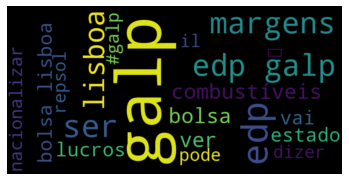

In [55]:
wordcloud(df_galp_freq['freq'], max_words=20, additional_stopwords=['porque'])

#### 4.2. Wordcloud with term frequency (weighted)

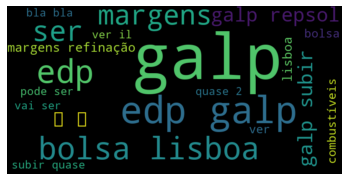

In [56]:
wordcloud(df_galp_freq['weighted_freq'], max_words=20, additional_stopwords=['porque'])